<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/03-node-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='red'>Disclaimer: this notebook is still a work in progress</font>

In [1]:
%pip install karateclub==1.2.2

     |████████████████████████████████| 62 kB 374 kB/s 
     |████████████████████████████████| 1.8 MB 19.8 MB/s 
     |████████████████████████████████| 24.1 MB 2.8 kB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.2-py3-none-any.whl size=97744 sha256=fdd102459b7dd61bb90d92dfb7f6b9f0ee27ffc5c87aadb2ec0a41bce97c317d
  Stored in directory: /root/.cache/pip/wheels/14/4b/99/abc777e42da28bc43b6959267f4f1c5eee06814a5c608a9ed2
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149863 sha256=cae196b89304ac7e380277ec77c871f73bfcdae564e81a8cf310b5a0fb718d14
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built karateclub python-Levenshtein
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Node Embeddings

In [2]:
import random
import time
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import clear_output, display

In [3]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

# Random Walk

In [4]:
class RandomWalk:
    def __init__(
        self,
        G: nx.Graph,
        node_size: int = 1500,
        width: int = 2,
        font_size: int = 16,
        fig_size: Tuple[int, int] = (8, 6),
        seed: int = 42,
    ) -> None:
        self.G = G
        self.node_size = node_size
        self.width = width
        self.font_size = font_size
        self.fig_size = fig_size
        self.seed = seed

    def _draw(self, ax: plt.Axes) -> None:
        node_colors = [
            "tab:blue"
            if node == self.current_node
            else "tab:orange"
            if node == self.starting_node
            else "tab:gray"
            if node in self.visited_nodes
            else "white"
            for node in self.G.nodes
        ]
        edge_colors = ["tab:gray" if sorted(edge) in self.visited_edges else "black" for edge in self.G.edges]
        pos = nx.spring_layout(self.G, seed=self.seed)

        nx.draw(
            self.G,
            pos=pos,
            ax=ax,
            node_color=node_colors,
            edgecolors="black",
            edge_color=edge_colors,
            node_size=self.node_size,
            width=self.width,
            font_size=self.font_size,
            with_labels=True,
        )

    def run(self, num_steps: int = 5, sleep_seconds: float = 0.5) -> None:
        self.starting_node = random.choice(list(self.G.nodes))
        self.current_node = self.starting_node
        self.visited_nodes = [self.current_node]
        self.visited_edges = []
        title = f"Random walk ({num_steps} steps): {self.current_node}"

        fig = plt.gcf()
        ax = fig.gca()
        self._draw(ax)
        plt.title(title, fontsize=self.font_size, loc="left")
        display(fig)
        clear_output(wait=True)

        for _ in range(num_steps):
            previous_node = self.current_node
            self.current_node = random.choice(list(self.G.neighbors(previous_node)))
            self.visited_edges.append(sorted((previous_node, self.current_node)))
            self.visited_nodes.append(self.current_node)
            title += f" -> {self.current_node}"

            time.sleep(sleep_seconds)
            self._draw(ax)
            plt.title(title, fontsize=self.font_size, loc="left")
            display(fig)
            clear_output(wait=True)

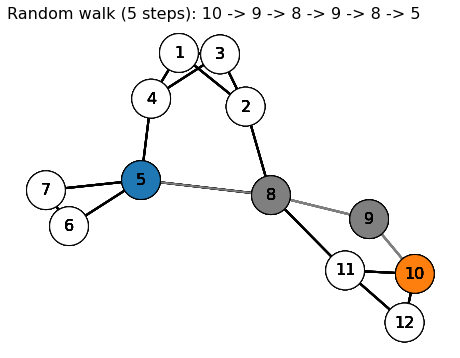

In [5]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (2, 8),
    (3, 4),
    (4, 5),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (8, 9),
    (8, 11),
    (9, 10),
    (10, 11),
    (10, 12),
    (11, 12),
]
G = nx.Graph(edge_list)
random_walk = RandomWalk(G)

plt.figure(figsize=(8, 6))
random_walk.run()
plt.show()

# How should we randomly walk?

In [6]:
from karateclub import Estimator
from sklearn.cluster import KMeans

In [7]:
def get_embedding_and_cluster(
    G: nx.Graph, model: Estimator, n_clusters: int = 4, node_size: int = 500, font_size: int = 16, seed: int = 42
) -> np.ndarray:
    model.fit(G.copy())
    embedding = model.get_embedding()
    labels = KMeans(n_clusters).fit_predict(embedding)

    cmap = plt.get_cmap("tab10")
    pos = nx.spring_layout(G, seed=seed)

    nx.draw(G, pos=pos, node_color=[cmap(label) for label in labels], node_size=node_size, with_labels=True)
    plt.title(
        f"Colored nodes based on clusters identified by K-Means (K={n_clusters})"
        f"\n on embeddings extracted with {type(model).__name__}",
        fontsize=font_size,
    )
    return labels

In [8]:
G = nx.karate_club_graph()

## DeepWalk

In [9]:
from karateclub import DeepWalk

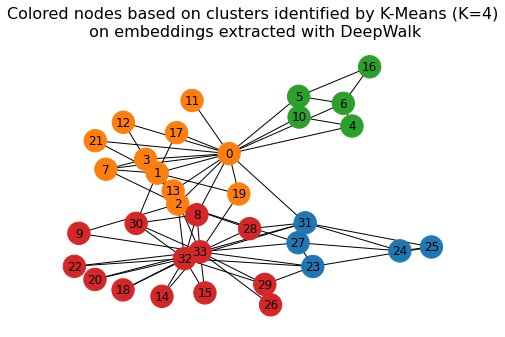

In [10]:
labels = get_embedding_and_cluster(G, DeepWalk(dimensions=16))

## Node2Vec

In [11]:
from karateclub import Node2Vec

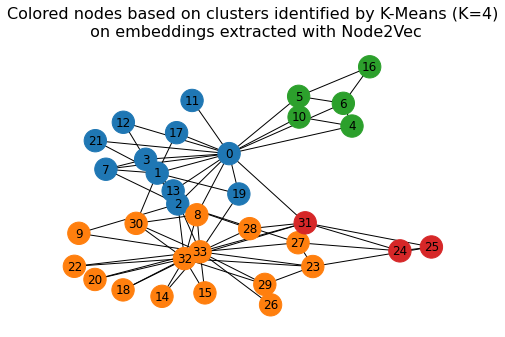

In [12]:
labels = get_embedding_and_cluster(G, Node2Vec(dimensions=16))

# Approach 1

# Approach 2

TODO (I haven't found an implementation yet)

# Approach 3